In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [3]:
from loguru import logger
import os
import librosa
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from scripts.mfcc_extractor import MfccExtractor
from scripts.pitch_extractor import PitchExtractor
from scripts.rms_extractor import RmsExtractor
from scripts.zcr_extractor import ZcrExtractor
import pandas as pd
import concurrent.futures
import logging

class StatisticFeatureExtraction:
    def __init__(self, n_mfcc=20):
        self.n_mfcc = n_mfcc

    def extract_mfcc_statistics(self, signal, sample_rate):
        mfcc_extractor = MfccExtractor(signal, sample_rate, self.n_mfcc)
        features = mfcc_extractor.compute_mfccs_statistics()
        feature_data = {}
        for i, (mean, var, max_val, min_val, median, p25, p75, rng, skewness, kurt, energy) in enumerate(zip(
                features['mfcc_mean'],
                features['mfcc_variance'],
                features['mfcc_max'],
                features['mfcc_min'],
                features['mfcc_median'],
                features['mfcc_25th_percentile'],
                features['mfcc_75th_percentile'],
                features['mfcc_range'],
                features['mfcc_skewness'],
                features['mfcc_kurtosis'],
                features['mfcc_energy'])):
            feature_data[f'mfcc_mean_{i+1}'] = mean
            feature_data[f'mfcc_variance_{i+1}'] = var
            feature_data[f'mfcc_max_{i+1}'] = max_val
            feature_data[f'mfcc_min_{i+1}'] = min_val
            feature_data[f'mfcc_median_{i+1}'] = median
            feature_data[f'mfcc_25th_percentile_{i+1}'] = p25
            feature_data[f'mfcc_75th_percentile_{i+1}'] = p75
            feature_data[f'mfcc_range_{i+1}'] = rng
            feature_data[f'mfcc_skewness_{i+1}'] = skewness
            feature_data[f'mfcc_kurtosis_{i+1}'] = kurt
            feature_data[f'mfcc_energy_{i+1}'] = energy

        return feature_data

    def extract_pitch_statistics(self, signal, sample_rate):
        pitch_extractor = PitchExtractor(signal, sample_rate)
        return pitch_extractor.compute_pitch_statistics()

    def extract_zcr_statistics(self, signal, frame_size, hop_size):
        zcr_extractor = ZcrExtractor(signal, frame_size, hop_size)
        return zcr_extractor.compute_zcr_statistics()

    def extract_rms_statistics(self, signal, frame_size, hop_size):
        rms_extractor = RmsExtractor(signal, frame_size, hop_size)
        return rms_extractor.compute_rms_statistics()

    def feature_engineering_for_file(self, audio_file, target_seconds=180):
        try:
            signal, sample_rate = librosa.load(audio_file, sr=None)
            if len(signal) >= 2048:
                features = {}
                
                # MFCC features
                mfcc_stats = self.extract_mfcc_statistics(signal, sample_rate)
                features.update({f'{key}': value for key, value in mfcc_stats.items()})

                # ZCR features
                zcr_stats = self.extract_zcr_statistics(signal, frame_size=2048, hop_size=512)
                features.update({f'zcr_{key}': value for key, value in zcr_stats.items()})

                # Pitch features
                pitch_stats = self.extract_pitch_statistics(signal, sample_rate)
                features.update({f'pitch_{key}': value for key, value in pitch_stats.items()})

                # RMS features
                rms_stats = self.extract_rms_statistics(signal, frame_size=2048, hop_size=512)
                features.update({f'rms_{key}': value for key, value in rms_stats.items()})

                return features
            
        except Exception as e:
            logger.error(f"Error processing file {audio_file}: {e}")
        return None

    def process_folder(self, input_folder, csv_file):
      file_and_label_df = pd.read_csv(csv_file)
      feature_dataframes = pd.DataFrame()  # DataFrame để lưu trữ các features từ tất cả các file âm thanh

      for index, row in file_and_label_df.iterrows():
          file_path = row['cleaned_file_path']
          label = row['label']
          features = self.feature_engineering_for_file(file_path)

          if index % 100 == 0:
              logger.info(f'Processed {index} file!')
              feature_dataframes.to_csv('vi_train_feature_data.csv', index=False)

          if features is not None:
              features['file_path'] = file_path
              features['label'] = label
              feature_dataframe = pd.DataFrame([features])  # Tạo DataFrame từ features của mỗi file
              feature_dataframes = pd.concat([feature_dataframes, feature_dataframe], ignore_index=True)  # Kết hợp DataFrame mới vào DataFrame tổng hợp

      # Lưu DataFrame tổng hợp vào tệp CSV
      feature_dataframes.to_csv('vi_train_feature_data.csv', index=False)


feature_extractor = StatisticFeatureExtraction()
feature_extractor.process_folder(r'D:\data_analysis\speech_emotion_recognition\data\VietnameseDataset\train_test_splited_data\cleaned_data\train', r"D:\data_analysis\speech_emotion_recognition\data\VietnameseDataset\train_test_splited_data\cleaned_data\train_file_paths_with_labels.csv")

2024-05-30 19:14:41.704 | INFO     | __main__:process_folder:99 - Processed 0 file!
2024-05-30 19:15:26.987 | INFO     | __main__:process_folder:99 - Processed 100 file!
2024-05-30 19:16:38.502 | INFO     | __main__:process_folder:99 - Processed 200 file!
2024-05-30 19:18:11.144 | INFO     | __main__:process_folder:99 - Processed 300 file!
2024-05-30 19:19:08.817 | INFO     | __main__:process_folder:99 - Processed 400 file!
2024-05-30 19:20:06.431 | INFO     | __main__:process_folder:99 - Processed 500 file!
2024-05-30 19:21:12.554 | INFO     | __main__:process_folder:99 - Processed 600 file!
2024-05-30 19:22:21.460 | INFO     | __main__:process_folder:99 - Processed 700 file!
2024-05-30 19:22:26.604 | ERROR    | __main__:feature_engineering_for_file:86 - Error processing file D:\data_analysis\speech_emotion_recognition\data\VietnameseDataset\train_test_splited_data\cleaned_data\train\segment_268_2.wav: 'tuple' object has no attribute 'items'
2024-05-30 19:22:27.146 | ERROR    | __main

In [12]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from loguru import logger

train_data = pd.read_csv(r'D:\data_analysis\speech_emotion_recognition\src\feature_extraction\merged_train_feature_data.csv')
val_data = pd.read_csv(r'D:\data_analysis\speech_emotion_recognition\src\feature_extraction\validation_feature_data.csv')
test_data = pd.read_csv(r'D:\data_analysis\speech_emotion_recognition\src\feature_extraction\test_feature_data.csv')

X_train = train_data.drop(columns=['label', 'file_path'])
y_train = train_data['label']

X_val = val_data.drop(columns=['label', 'file_path'])
y_val = val_data['label']

X_test = test_data.drop(columns=['label', 'file_path'])
y_test = test_data['label']

X_train_combined = pd.concat([X_train, X_val])
y_train_combined = pd.concat([y_train, y_val])

scaler = StandardScaler()
X_train_combined = scaler.fit_transform(X_train_combined)
X_test = scaler.transform(X_test)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

grid_search.fit(X_train_combined, y_train_combined)

best_params = grid_search.best_params_
logger.info(f"Best parameters found: {best_params}")

best_rf = grid_search.best_estimator_
best_rf.fit(X_train_combined, y_train_combined)

y_test_pred = best_rf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_report = classification_report(y_test, y_test_pred)

logger.info(f"Test Accuracy: {test_accuracy}")
logger.info(f"Test Classification Report:\n{test_report}")

print(f"Test Accuracy: {test_accuracy}")
print(f"Test Classification Report:\n{test_report}")


Fitting 5 folds for each of 108 candidates, totalling 540 fits


2024-05-30 10:01:26.880 | INFO     | __main__:<module>:49 - Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
2024-05-30 10:03:23.785 | INFO     | __main__:<module>:60 - Test Accuracy: 0.6509711595055915
2024-05-30 10:03:23.786 | INFO     | __main__:<module>:61 - Test Classification Report:
              precision    recall  f1-score   support

       Angry       0.74      0.80      0.77       557
   Disgusted       0.64      0.50      0.56       543
     Fearful       0.79      0.46      0.58       558
       Happy       0.64      0.64      0.64       549
     Neutral       0.50      0.70      0.59       475
         Sad       0.60      0.75      0.67       536
    Suprised       0.90      0.86      0.88       180

    accuracy                           0.65      3398
   macro avg       0.69      0.67      0.67      3398
weighted avg       0.67      0.65      0.65      3398



Test Accuracy: 0.6509711595055915
Test Classification Report:
              precision    recall  f1-score   support

       Angry       0.74      0.80      0.77       557
   Disgusted       0.64      0.50      0.56       543
     Fearful       0.79      0.46      0.58       558
       Happy       0.64      0.64      0.64       549
     Neutral       0.50      0.70      0.59       475
         Sad       0.60      0.75      0.67       536
    Suprised       0.90      0.86      0.88       180

    accuracy                           0.65      3398
   macro avg       0.69      0.67      0.67      3398
weighted avg       0.67      0.65      0.65      3398



In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization
Normalized confusion matrix


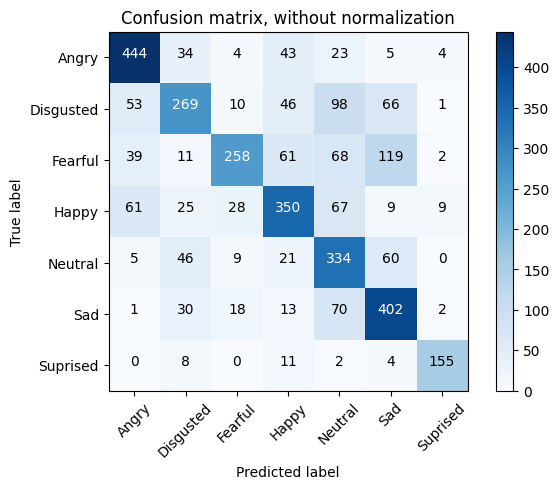

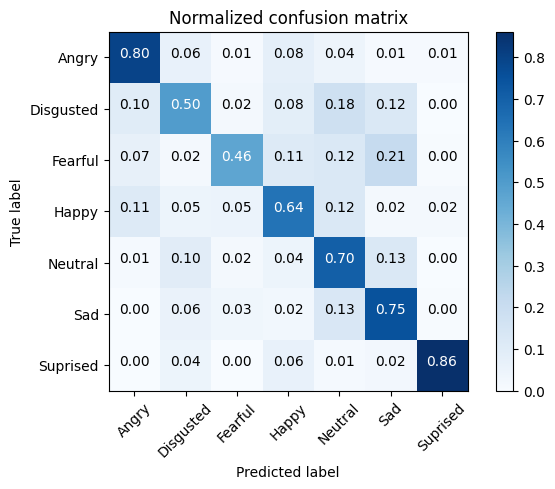

In [16]:
class_names = ["Angry", "Disgusted", "Fearful", "Happy", "Neutral", "Sad", "Suprised"]

# Calculate confusion matrix
cnf_matrix = confusion_matrix(y_test, y_test_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [5]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from loguru import logger

train_data = pd.read_csv(r'D:\data_analysis\speech_emotion_recognition\src\feature_extraction\vi_train_feature_data.csv')
test_data = pd.read_csv(r'D:\data_analysis\speech_emotion_recognition\src\feature_extraction\vi_test_feature_data.csv')

X_train = train_data.drop(columns=['label', 'file_path'])
y_train = train_data['label']

# X_val = val_data.drop(columns=['label', 'file_path'])
# y_val = val_data['label']

X_test = test_data.drop(columns=['label', 'file_path'])
y_test = test_data['label']

X_train_combined = X_train
y_train_combined = y_train

scaler = StandardScaler()
X_train_combined = scaler.fit_transform(X_train_combined)
X_test = scaler.transform(X_test)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

grid_search.fit(X_train_combined, y_train_combined)

best_params = grid_search.best_params_
logger.info(f"Best parameters found: {best_params}")

best_rf = grid_search.best_estimator_
best_rf.fit(X_train_combined, y_train_combined)

y_test_pred = best_rf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_report = classification_report(y_test, y_test_pred)

logger.info(f"Test Accuracy: {test_accuracy}")
logger.info(f"Test Classification Report:\n{test_report}")

print(f"Test Accuracy: {test_accuracy}")
print(f"Test Classification Report:\n{test_report}")


Fitting 5 folds for each of 108 candidates, totalling 540 fits


2024-05-30 19:28:34.247 | INFO     | __main__:<module>:40 - Best parameters found: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
2024-05-30 19:28:36.415 | INFO     | __main__:<module>:49 - Test Accuracy: 0.6341463414634146
2024-05-30 19:28:36.416 | INFO     | __main__:<module>:50 - Test Classification Report:
              precision    recall  f1-score   support

       Angry       0.66      0.74      0.70        39
   Disgusted       0.21      0.20      0.21        15
     Fearful       1.00      0.33      0.50         9
       Happy       1.00      0.83      0.91         6
     Neutral       0.68      0.76      0.72        42
         Sad       0.60      0.50      0.55        12

    accuracy                           0.63       123
   macro avg       0.69      0.56      0.60       123
weighted avg       0.65      0.63      0.63       123



Test Accuracy: 0.6341463414634146
Test Classification Report:
              precision    recall  f1-score   support

       Angry       0.66      0.74      0.70        39
   Disgusted       0.21      0.20      0.21        15
     Fearful       1.00      0.33      0.50         9
       Happy       1.00      0.83      0.91         6
     Neutral       0.68      0.76      0.72        42
         Sad       0.60      0.50      0.55        12

    accuracy                           0.63       123
   macro avg       0.69      0.56      0.60       123
weighted avg       0.65      0.63      0.63       123



Confusion matrix, without normalization
Normalized confusion matrix


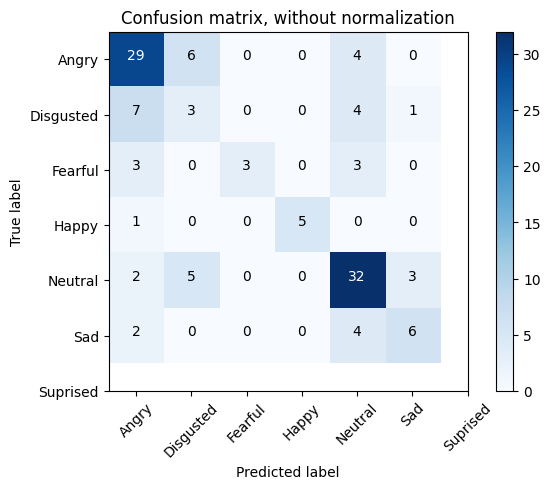

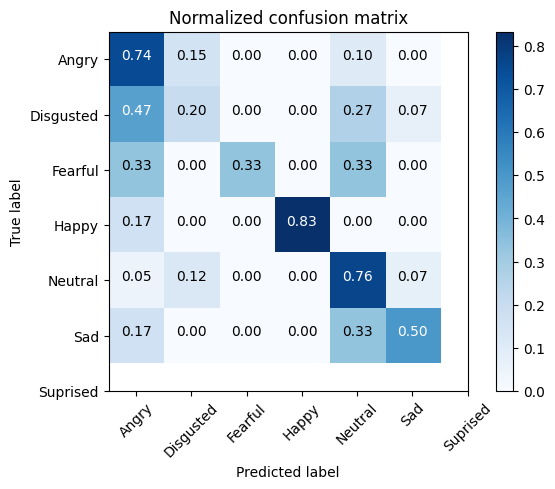

In [8]:
class_names = ["Angry", "Disgusted", "Fearful", "Happy", "Neutral", "Sad", "Suprised"]

# Calculate confusion matrix
cnf_matrix = confusion_matrix(y_test, y_test_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()